In [1]:
import pandas as pd
from scipy.io import mmread
import scanpy as sc
import os
import sys
sys.path.append(os.path.abspath('../../src'))
import SortedNoDupeBedOverlap as bdO
import io_utils
import stats_utils

## download required
please download atac_v1_pbmc_5k_filtered_peak_bc_matrix.tar.gz from

https://support.10xgenomics.com/single-cell-atac/datasets/1.2.0/atac_pbmc_5k_v1

and

tar -xf atac_v1_pbmc_5k_filtered_peak_bc_matrix.tar.gz

In [2]:
mat, id2bc, id2peak = io_utils.read_atac_count_10x('filtered_peak_bc_matrix', verbose = False)

In [3]:
ref_subtype_peaks0, ref_bk_peak = io_utils.read_reference_data('../../OCR_DB/GSE129785/', verbose = False)

In [4]:
intersect = set(bdO.BedOverlap(sorted(id2peak), sorted(ref_bk_peak), .5))

In [5]:
len(intersect)

71161

In [6]:
ref_subtype_peaks = []
for c, peaks in ref_subtype_peaks0:
    ref_subtype_peaks.append( (c, set(bdO.BedOverlap(sorted(id2peak), sorted(peaks), .5))) )

In [7]:
for c, peaks in ref_subtype_peaks:
    print(c, len(peaks))

Basophil 990
CLP 2580
CMP_BMP 2587
Central_memory_CD8_T 2918
Effector_memory_CD8_T 510
GMP 5175
Gamma_delta_T 767
HSC_MPP 1726
Immature_NK 907
LMPP 2281
MDP 5797
MEP 2460
Mature_NK1 2532
Mature_NK2 290
Memory_B 2157
Memory_CD4_T 1258
Monocyte_1 6890
Monocyte_2 3645
Naive_B 1608
Naive_CD4_T1 1167
Naive_CD4_T2 2286
Naive_CD8_T1 275
Naive_CD8_T2 169
Naive_CD8_T3 893
Naive_Treg 125
Plasma_cell 4138
Pre-B 2606
Pro-B 1318
Treg 606
cDC 10257
pDC 2776


In [8]:
mat.shape, len(id2peak)

((4654, 84626), 84626)

In [9]:
scores = stats_utils.compute_enrichment_score(mat, set(intersect), id2peak, ref_subtype_peaks, num_cores = 10)

In [10]:
score_df = pd.DataFrame(scores, 
                        columns = [c for c, _ in ref_subtype_peaks],
                       index = id2bc
                       )

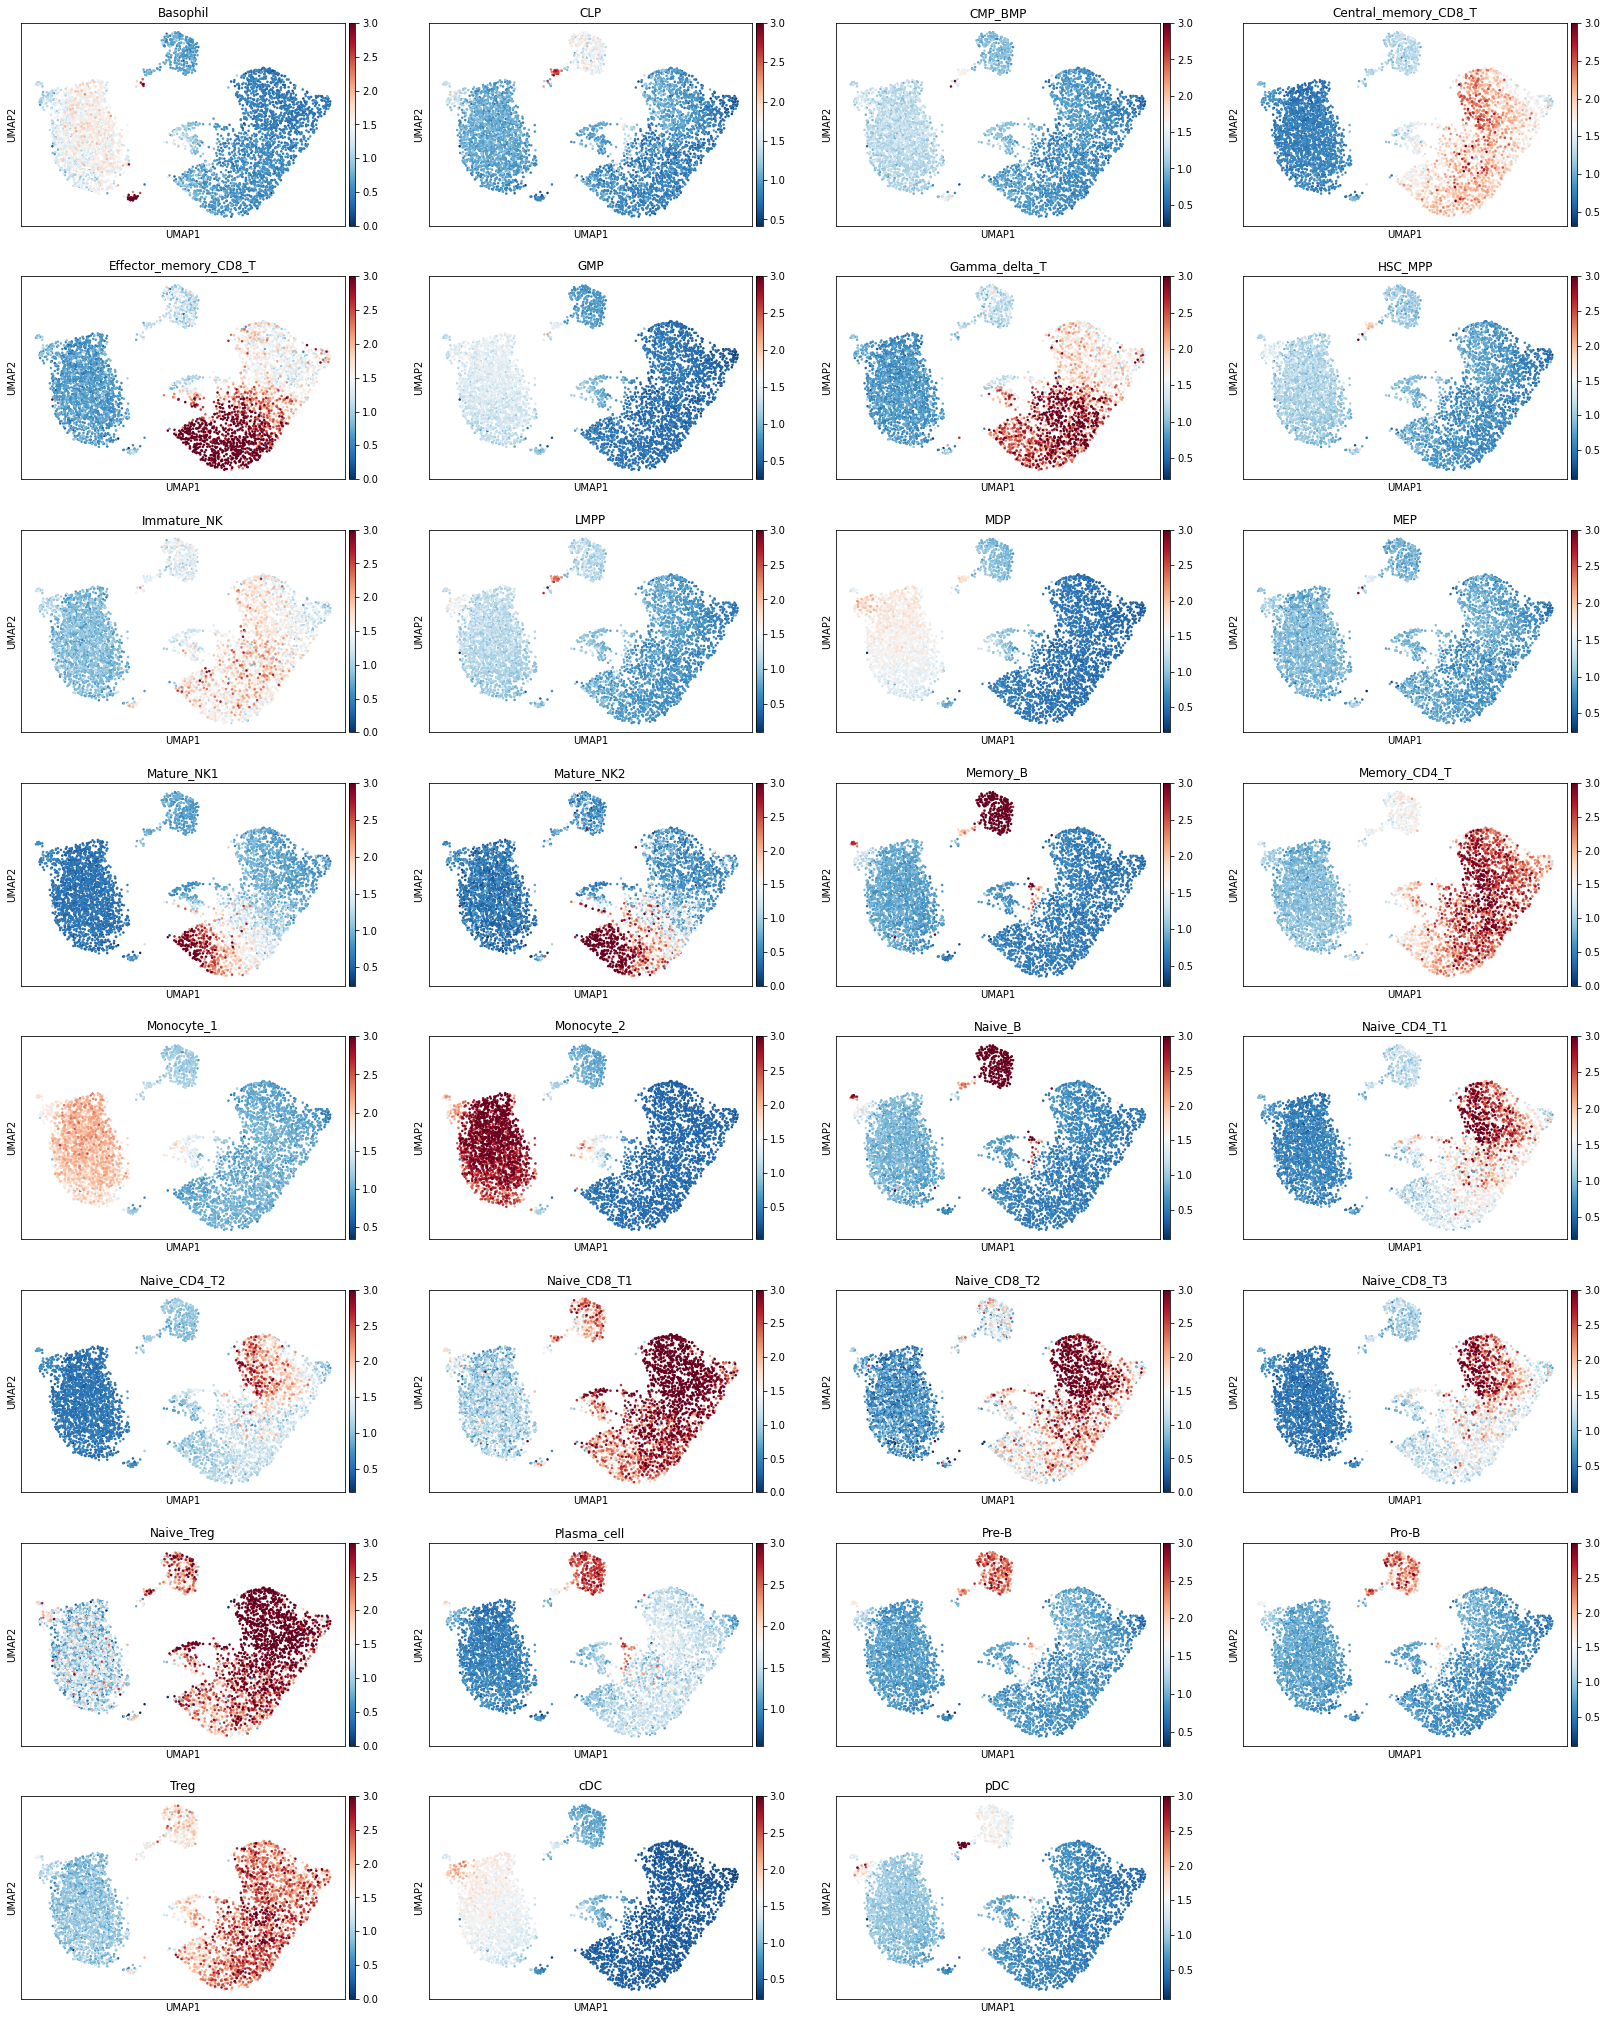

In [11]:
## visualization using scanpy
pcas = stats_utils.normalized_pca_from_sparse_mat(mat, n_pc = 20) 
            
data_obj = sc.AnnData(pcas, 
      obs = pd.DataFrame([], index = id2bc),
      )        

sc.pp.neighbors(data_obj, use_rep='X')
sc.tl.umap(data_obj) 

data_obj.obs = score_df

sc.pl.umap(data_obj, color = score_df.columns, cmap = 'RdBu_r', vmax = 3)